##### 题目五（扩展）：使用 numpy 编写逻辑回归算法，对 iris 数据进行多分类

In [8]:
import sklearn
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

plt.rcParams['font.family'] = 'SimHei'      # 中文正常显示
plt.rcParams['axes.unicode_minus'] = False  # 符号正常显示

In [9]:
# 在下面这个实现中，主要使用了 CrossEntropy Loss（交叉熵损失） + softmax（激活函数） 策略来处理多分类任务
class MultiClassLogisticRegression:
    def __init__(self, coef_shape, intercept_shape, learning_rate=0.01, epochs=1000):
        self.coef = np.random.randn(*coef_shape)
        self.intercept = np.random.randn(*intercept_shape)
        self.learning_rate = learning_rate
        self.epochs = epochs

    @staticmethod   # staticmethod 修饰的函数，可以直接通过类名调用，不需要实例化对象
    def one_hot(y):# 将标签进行 one-hot 编码
        return np.eye(3)[y.flatten()]

    def predict(self, X):
        # X.shape[1] 为输入矩阵的第二个维度，即特征的数量
        # 在预测阶段，模型会将输入特征和系数矩阵相乘并加上截距，得到一个预测值
        # 然后对这个预测值应用 softmax ，得到每个类别的预测概率。最后选概率最大的类别作为预测结果。
        if X.shape[1] != self.coef.shape[0]:
            raise ValueError("输入矩阵的第二个维度必须与coef匹配！")
        value = np.dot(X, self.coef) + self.intercept
        proba = np.exp(value)
        proba = proba / np.sum(proba, axis=1, keepdims=True)    # softmax 应用，得到每个类别的预测概率
        result = np.argmax(proba, axis=1).reshape(-1, 1)
        return value, proba, result

    @staticmethod
    def cross_entropy_loss(label, proba):
        # 交叉熵损失函数: 这是逻辑回归中常用的损失函数，可衡量模型预测结果与真实结果之间的一致性
        # 通过最小化交叉熵损失函数，可以使模型的预测结果更接近真实结果
        # label 为 one-hot 编码后的标签，proba 为预测的概率
        loss = -np.sum(label * np.log(proba), axis=0)   # 交叉熵损失越小，说明预测的结果越准确
        return loss.sum()

    def update(self, X, label, lr=0.001):
        # 更新参数，lr 为学习率，X 为输入矩阵，label 为 one-hot 编码后的标签
        value, proba, _ = self.predict(X)
        self.coef -= lr * np.dot(X.T, proba - label)
        self.intercept -= lr * np.sum(proba - label)
        return self.cross_entropy_loss(label, proba)

    def train(self, X_train, y_train):
        lost_list = []
        for epoch in range(self.epochs):
            # 每次迭代，都会调用一次 update 函数，更新模型参数
            _lr = self.learning_rate * np.power((1 - float(epoch) / self.epochs), 4)# 学习率衰减
            loss = self.update(X_train, self.one_hot(y_train), lr=_lr)  # 更新参数，返回交叉熵损失
            if not epoch % int(self.epochs / 100):
                lost_list.append(loss)
            if not epoch % int(self.epochs / 10):
                print("epoch:", epoch, "交叉熵损失值:", loss)
        # 每次调用训练函数，都绘制一次损失函数的变化曲线
        plt.plot(lost_list)
        plt.title("交叉熵损失值随着训练轮次的变化曲线")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.show()

    def plot_decision_boundary(self, X, y):
        # 绘制决策边界
        color = ["r", "g", "b"]
        marker = ["o", "v", "x"]
        class_label = np.unique(y)
        # 为每个类别分配一种颜色
        cmap = ListedColormap(color[: len(class_label)])
        x1_min, x2_min = np.min(X, axis=0)
        x1_max, x2_max = np.max(X, axis=0)
        x1 = np.arange(x1_min - 1, x1_max + 1, 0.02)
        x2 = np.arange(x2_min - 1, x2_max + 1, 0.02)
        # 生成网格点坐标矩阵
        X1, X2 = np.meshgrid(x1, x2)
        # 将网格点坐标矩阵作为输入，调用 predict 函数，得到预测结果
        Z = np.array(self.predict(np.array([X1.ravel(), X2.ravel()]).T)[2]).reshape(X1.shape)
        plt.contourf(X1, X2, Z, cmap=cmap, alpha=0.5)
        for i, class_ in enumerate(class_label):
            plt.scatter(x=X[y == class_, 0], y=X[y == class_, 1], c=cmap.colors[i], label=class_, marker=marker[i])
        plt.legend()
        plt.show()

    def stratified_train_test_split(self, X, y, test_ratio, random_seed):
        # 分层划分训练集和测试集，用于替代 train_test_split 函数
        np.random.seed(random_seed)
        classes = np.unique(y)
        X_train, X_test, y_train, y_test = [], [], [], []
        for c in classes:
            # 对每个类别，都按照相同的比例划分训练集和测试集
            idx = np.where(y == c)[0]
            np.random.shuffle(idx)  # 打乱索引
            test_size = int(len(idx) * test_ratio)
            X_test.extend(X[idx[:test_size]])
            y_test.extend(y[idx[:test_size]])
            X_train.extend(X[idx[test_size:]])
            y_train.extend(y[idx[test_size:]])
        return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)


    @staticmethod
    def draw_confusion_matrix(y_test, test_pre):
        confusion = confusion_matrix(y_test, test_pre)
        print(confusion)
        plt.imshow(confusion, cmap=plt.cm.Blues)
        indices = range(len(confusion))
        classes = list(set(y_test.flatten()))
        classes.sort()
        plt.xticks(indices, classes)
        plt.yticks(indices, classes)
        for i in range(len(confusion)):
            for j in range(len(confusion[i])):
                plt.text(j, i, confusion[i][j], c='y', fontsize=13)
        plt.colorbar()
        plt.xlabel('predict')
        plt.ylabel('true')
        plt.show()


epoch: 0 交叉熵损失值: 375.856267700082
epoch: 100 交叉熵损失值: 25.3839605285108
epoch: 200 交叉熵损失值: 22.44975371132436
epoch: 300 交叉熵损失值: 21.36957434542516
epoch: 400 交叉熵损失值: 20.887970499235493
epoch: 500 交叉熵损失值: 20.66773185311537
epoch: 600 交叉熵损失值: 20.573628404159187
epoch: 700 交叉熵损失值: 20.539423169520877
epoch: 800 交叉熵损失值: 20.530237233194164
epoch: 900 交叉熵损失值: 20.52888439441695


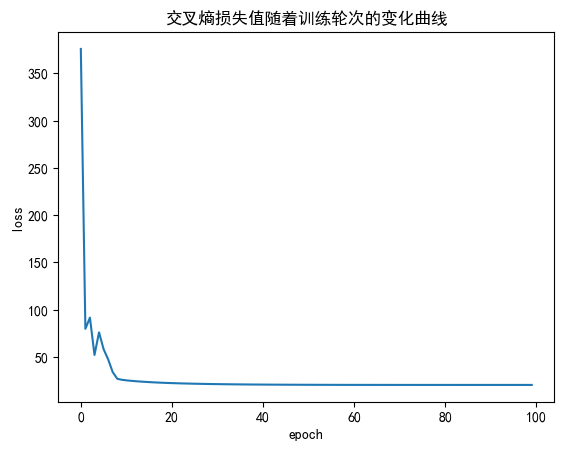

[[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]


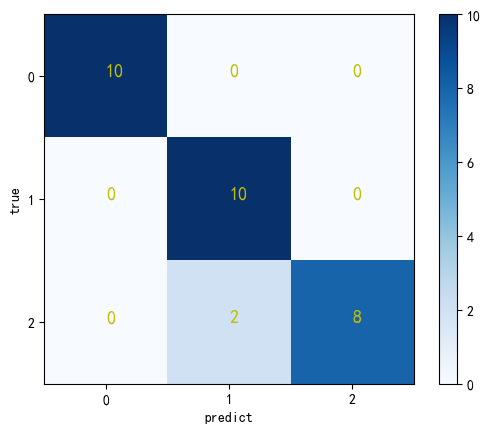

准确率: 0.9333333333333333


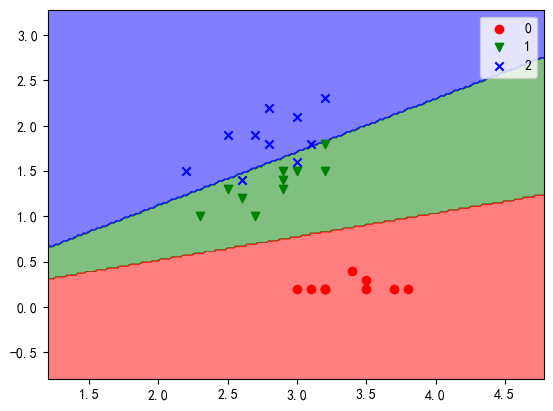

In [10]:
# 加载数据集
X, y = load_iris(return_X_y=True)
features = [1,3]
X = X[:, features]

# 初始化模型
model = MultiClassLogisticRegression(coef_shape=(2, 3), intercept_shape=(1, 3))

# 分割数据集
X_train, X_test, y_train, y_test = model.stratified_train_test_split(X, y, test_ratio=0.2, random_seed=1)

# 训练模型
model.train(X_train, y_train)

# 预测
preds = model.predict(X_test)[2]

# 绘制混淆矩阵
model.draw_confusion_matrix(y_test, preds)

# 计算准确率
print("准确率:", accuracy_score(y_test, preds))

# 绘制决策边界
model.plot_decision_boundary(X_test, y_test)
# 从混淆矩阵 
# [[10  0  0]
#  [ 0 10  0]
#  [ 0  2  8]]
